# Mouse Maze 

A maze solved with 3 different levels of information.

1. MDP
2. POMDP
3. No state information

Ideas:
Add 'wind' to maze
Add telporters and traps
Maybe secret passages?
Keys and doors?

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import kruskal
import gym
from gym import error, spaces, utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# utility functions
def clip(x,low,high):
    if x < low: return low
    if x > high: return high
    return x

In [28]:
class Maze(gym.Env):        
    """ MDP verson of maze. 
        State is our x,y location.
    """
    
    metadata = {
        "render.modes": ["human", "rgb_array"],
    }
    
    ACTIONS = ['north','south','east','west']        
    DELTAS = [(0,-1),(0,+1),(-1,0),(+1,0)]                
        
    def __init__(self, width, height):
        self.width = width
        self.height = height        
        self.tile = np.zeros((width, height))
        self.action_space = spaces.Discrete(len(self.ACTIONS))
        self.observation_space = spaces.Box(np.array([0,0]),np.array([width,height]))
        
        self.state = (0,0)        
       
    # ----------------------------------
    # Open AI interface
    # ----------------------------------
    
    def _reset():
        """ reset enviroment and return inital observation. """
        self.state = self.start
        return self.state
    
    def _render(self, mode="human", close=False):
        # not implemented yet...
        output = self.tile
        x,y = self.state
        output[x,y] = -1
        return output
    
    def _step(self, action):
        assert isinstance(action, int), "Action must be of type int."
        self.move(self.DELTAS[action])
        reward = 1 if self.at_goal() else -0.1
        done = (reward == 1)
        info = {}
        return (self.state, reward, done, info)
        
    # ----------------------------------
    # General
    # ----------------------------------
    
    def at_goal(self):
        return self.state == self.goal
    
    def move(self, dx, dy):
        x,y = self.state
        x += dx 
        y += dy        
        if self.can_move(x,y):
            self.state = (x,y)
        else:
            # invalid move
            pass                            
    
    def generate_random(self, seed=None):
        """ generate a random maze using kruskals algorithm"""
        
        assert self.width >= 3 and \
            self.height >= 3 and \
            self.width % 2 == 1 and \
            self.height % 2 == 1, \
            "Width and height must be >=3 and odd."
        
        if seed is not None:
            np.random.seed(seed)
            
        # The idea is to use kruskals with random weights on a smaller grid then expand the grid out
        # so that there are rooms for the walls inbetween the tiles.
            
        h_width = self.width // 2
        h_height = self.height // 2
            
        g = kruskal.Graph(h_width*h_height)

        def in_bounds(x,y):
            return x >= 0 and y >= 0 and x < h_width and y < h_height

        def add_edge(g,x1,y1,x2,y2, cost):
            if in_bounds(x1,y1) and in_bounds(x2,y2):
                g.addEdge(x1+y1*h_width, x2+y2*h_width, cost)
                g.addEdge(x2+y2*h_width, x1+y1*h_width, cost)                

        for x in range(h_width):
            for y in range(h_height):
                for dx,dy in self.DELTAS:
                    add_edge(g,x,y,x+dx,y+dy,np.random.randint(1,10))

        graph = g.KruskalMST()
        
        self.tile = np.ones((self.width, self.height))
        
        start = (np.random.randint(h_width), np.random.randint(h_height))
        goal = (np.random.randint(h_width), np.random.randint(h_height))        
        
        # save start location for later
        self.start = (start[0]*2+1, start[1]*2+1) 
        self.goal = (goal[0]*2+1, goal[1]*2+1) 
        
        # fill in rooms
        for x in range(h_width):
            for y in range(h_height):    
                mask = 0
                if ((x,y)==start): mask += 2
                if ((x,y)==goal): mask += 4
                self.tile[x*2+1,y*2+1] = mask
        
        # convert from graph to walls 
        for head,tail,weight in graph:
            x1, y1 = head % h_width, head // h_width
            x2, y2 = tail % h_width, tail // h_width
            dx = x2-x1
            dy = y2-y1                        
            self.tile[x1*2+1+dx,y1*2+1+dy] = 0        
        
    
    def plot(self):
        """ plot the maze. """        
        plt.imshow(self.tile)
        plt.show()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


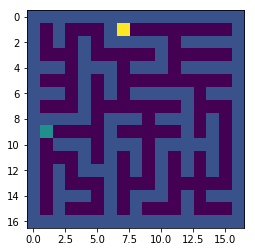

In [29]:
maze = Maze(17,17)
maze.generate_random(5)
maze.plot()

# 1 MDP

Solve the maze as a markov decision process.  We have perfect information in this case, so learning is realtively easy via q-learning.

We will implement the following 3 algorithms

* Sarasa
* TD-Learning
* Q-Learning

and evaluate how long it takes for them to converge on the optimal solution.